In [308]:
# For Define file path
import os

import shutil
import time
from threading import Timer
from time import gmtime, strftime

# for tranform image to data
import numpy as np
import pandas as pd

# for plat image
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

#used to label connected regions within an image.
from skimage import measure


import rasterio #for read image and process image data
from rasterio.transform import from_origin
from rasterio.enums import Resampling #for resample image to 10m
import geopandas as gpd #Create dataframe

#to make shape
from rasterio.features import shapes 
from shapely.geometry import shape 

#to read xml coordinate
from xml.etree import ElementTree as ET

import math

from rasterio.warp import transform

from osgeo import gdal

import warnings
import csv
warnings.filterwarnings(action='ignore') 

In [309]:
# Global variables:
systemCooldown = 2
Error_Limit = 1
mode = True

In [310]:
# File Paths
Drive = "/Users/imdsk/RIDAProjectBurnScar/Sentinel_Process/"
Image = os.path.join(Drive, "Image")
Image_Pre = os.path.join(Drive, "Image_Pre/")
Image_Finish = os.path.join(Drive, "Image_Finish/")
Image_Missing = os.path.join(Drive, "Image_Missing/")
Output = os.path.join(Drive, "Output/")
Rtbcon = os.path.join(Drive, "Raster_BurnCon/")
Rtbreg = os.path.join(Drive, "Raster_BurnReg/")
RtbShape = os.path.join(Drive, "Raster_BurnShape/")
RtbLevel = os.path.join(Drive, "Raster_BurnLevel/")
# Track_arr = ["2024/"]
Track_arr = ["2019/","2020/","2021/","2022/","2023/","2024/"]
# Track_arr = ["CropTest/","DoiChang/", "MaeJam/", "MyanMar/", "PhouXang/"]
# Track_arr = ["T4/", "T104/", "T61/", "T18/", "T118/"]

Function to load cooldown

In [311]:
# Function to load cooldown
def loadCooldown():
    global mode

Function to print time

In [312]:
# Function to print time
def print_time():
    return time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

Function to Move File

In [313]:
# Function to move file
def Move_File(FileName, CurrDir, DestDir):
    try:
        if os.path.exists(os.path.join(CurrDir, FileName)):
            if os.path.exists(os.path.join(DestDir, FileName)):
                os.remove(os.path.join(DestDir, FileName))
            shutil.copy(os.path.join(CurrDir, FileName), DestDir)
            t = Timer(1, loadCooldown)
            t.start()
            t.join()
            os.remove(os.path.join(CurrDir, FileName))
            print(print_time() + f"Raster_Process :: Move File {FileName} Complete")
    except Exception as e:
        print(print_time() + f"Raster_Process :: Can not Move File {FileName}")
        print(print_time() + str(e))

Functuin to Write CSV

In [314]:
# Function to Write CSV
def write_to_csv(data, file_name_csv):
    try:
        # Convert NumPy array to a nested Python list or dictionary
        if isinstance(data, np.ndarray):
            data_list = data.tolist()  # Convert ndarray to a nested list
        else:
            data_list = data  # For other non-ndarray data, assume it's already in list format

        # Write to CSV file
        with open(file_name_csv, 'w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)
            for row in data_list:
                csv_writer.writerow(row)
        print(f"Data successfully written to {file_name_csv}")

    except Exception as e:
        print(f"Error writing to CSV file: {e}")

def save_results_to_csv(data_arrays, csv_filenames, window_size, track):
    """Saves generated data arrays into CSV files within a track-specific folder"""

    output_dir = f"output_data/{track}"  # Example output structure
    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists

    for data, filename in zip(data_arrays, csv_filenames):
        full_path = os.path.join(output_dir, filename)
        np.savetxt(full_path, data, delimiter=',')


In [315]:
def print_with_tag(data, tag):
    print("------")
    print(tag)
    print(data)
    print("------")
    

# Function to Resample

```:
Example use:

input_raster = AFB12
output_raster = AFB1210
new_resolution = 10 

resample_raster(input_raster, output_raster, new_resolution)

```

In [316]:
# Function to Resample
def resample_raster(input_raster, output_raster, new_resolution):
                with rasterio.open(input_raster) as src:
                    transform = src.transform
                    data = src.read(
                        out_shape=(
                            src.count,
                            int(src.height * src.transform.a / new_resolution),
                            int(src.width * src.transform.a / new_resolution)
                        ),
                        resampling=Resampling.nearest  # You can adjust the resampling method here
                    )
                    profile = src.profile
                    profile.update(transform=transform, width=data.shape[2], height=data.shape[1])

                    with rasterio.open(output_raster, 'w', **profile) as dst:
                        dst.write(data)

# Function to Create Shape

```:
Example use:

input_raster = raster
output_path = Path/To/Destination + Short_name+ "_Example" + ".tif"
save_as_geotiff(input_raster, output_path)

```

In [317]:
# Function to Create Shape
def save_as_geotiff(data, output_path, resolution=10):
                    height, width = data.shape

                    # Define the transformation
                    transform = from_origin(0, height * resolution, resolution, -resolution)

                    # Define the profile
                    profile = {
                        'driver': 'GTiff',
                        'count': 1,
                        'dtype': 'uint8',
                        'width': width,
                        'height': height,
                        'crs': 'EPSG:4326',  # Adjust the CRS as needed
                        'transform': transform,
                        'compress': 'packbits',
                        'tiled': True,
                        'interleave': 'band',
                    }

                    with rasterio.open(output_path, 'w', **profile) as dst:
                        dst.write(data.astype('uint8'), 1)

# Crop Table

# Formula Calculate Indices
```:
BFB   Stand for Before burn
AFB   Stand for After burn
B02   Stand for Blue 
B03   Stand for Green 
B04   Stand for Red 
b08   Stand for VNIR (Visible Near Infared)
b12   Stand for SWIR (Shor Wave Infared)
b1210 Stand for SWIR Resample from 20m to 10m

nbr   Stand for Nomalize Burn Ratio
```

In [318]:

# def calculate_post_nbr(afb_B08,afb_B1210):
#                     post_nbr= (afb_B08 - afb_B1210) / (afb_B08 + afb_B1210) 
#                     return post_nbr

# def calculate_dnbr(pre_nbr,post_nbr):
#                     dnbr = pre_nbr - post_nbr        
#                     return dnbr

# def calculate_ndwi(afb_B03,afb_B08):             
#                     ndwi = (afb_B03 - afb_B08) / (afb_B03 + afb_B08) #(AFB03 - AFB08) /(AFB03 + AFB08)                
#                     return ndwi

# def calculate_ndvi(post_red,post_nir):                                 
#                     ndvi_data = (post_nir - post_red) / (post_nir + post_red) #(AFB08 - AFB04) / (AFB08 + AFB04)             
#                     return ndvi_data


# Condition to feature table



# Normalize

In [319]:
# def normalize_minmax(dNBR):
#     dNBR_normalized = (dNBR - dNBR.min()) / (dNBR.max() - dNBR.min())
#     return dNBR_normalized


# Crop Image


# Down sampling

In [320]:
# Function to process raster

def Raster_Process(Track):
    global mode, Image, Image_Pre, Image_Finish, Image_Missing, Output, Error_Limit

    Loop_Limit = 0
    image_track = os.path.join(Image, Track)
    output_track = os.path.join(Output, Track)

    rasters = [r for r in os.listdir(image_track) if r.endswith('B12.jp2')]

    for raster in rasters:
        if Loop_Limit > 0:
            mode = True
            return

        Full_name = os.path.splitext(raster)[0]
        Mid_name = Full_name[:23]
        Short_name = Full_name[:6]
        # Short_name = Full_name_parts[0] + '_' + Full_name_parts[1]
        # print(Full_name)
        # print(Short_name)

        BFB02 = os.path.join(Image_Pre, Track, f"{Short_name}_B02.jp2")
        BFB03 = os.path.join(Image_Pre, Track, f"{Short_name}_B03.jp2")
        BFB04 = os.path.join(Image_Pre, Track, f"{Short_name}_B08.jp2")
        BFB08 = os.path.join(Image_Pre, Track, f"{Short_name}_B08.jp2")
        BFB12 = os.path.join(Image_Pre, Track, f"{Short_name}_B12.jp2")
        BFB1210 = os.path.join(Image_Pre, Track, f"{Short_name}_B1210.jp2")
        BFNBR = os.path.join(Image_Pre, Track, f"{Short_name}_NBR.tif")

        AFB02 = os.path.join(Image, Track, f"{Mid_name}B02.jp2")
        AFB03 = os.path.join(Image, Track, f"{Mid_name}B03.jp2")
        AFB04 = os.path.join(Image, Track, f"{Mid_name}B04.jp2")
        AFB05 = os.path.join(Image, Track, f"{Mid_name}B05.jp2")
        AFB0510 = os.path.join(Image, Track, f"{Mid_name}B0510.jp2")
        AFB06 = os.path.join(Image, Track, f"{Mid_name}B06.jp2")
        AFB0610 = os.path.join(Image, Track, f"{Mid_name}B0610.jp2")
        AFB07 = os.path.join(Image, Track, f"{Mid_name}B07.jp2")
        AFB0710 = os.path.join(Image, Track, f"{Mid_name}B0710.jp2")
        AFB08 = os.path.join(Image, Track, f"{Mid_name}B08.jp2")
        AFB0810 = os.path.join(Image, Track, f"{Mid_name}B0810.jp2")
        AFB8A = os.path.join(Image, Track, f"{Mid_name}B8A.jp2")
        AFB8A10 = os.path.join(Image, Track, f"{Mid_name}B8A10.jp2")
        AFB09 = os.path.join(Image, Track, f"{Mid_name}B09.jp2")
        AFB0910 = os.path.join(Image, Track, f"{Mid_name}B0910.jp2")
        AFB12 = os.path.join(Image, Track, f"{Mid_name}B12.jp2")
        AFB1210 = os.path.join(Image, Track, f"{Mid_name}B1210.jp2")



        print(BFB12)
       

        if all(
            [ 
                os.path.exists(BFB02),os.path.exists(BFB03),os.path.exists(BFB04),os.path.exists(BFB08), os.path.exists(BFB12),
                os.path.exists(AFB02),os.path.exists(AFB03), os.path.exists(AFB04),os.path.exists(AFB05),os.path.exists(AFB06),os.path.exists(AFB07),os.path.exists(AFB8A),os.path.exists(AFB08), os.path.exists(AFB09), os.path.exists(AFB12)
                
            ]
        ):
            print(print_time() + "Raster_Process :: Start GIS Process Please Wait....")
            Loop_Limit += 1
            # Delete Old File
            print(print_time() + "Raster_Process :: Delete Old File")
            files = os.listdir(output_track)
            for f in files:
                try:
                    os.remove(os.path.join(output_track, f))
                except Exception as e:
                    print(print_time() + f"Raster_Process :: Cannot Delete {f}")
                    print(print_time() + str(e))
                    break

            print(print_time() + "Raster_Process :: Delete Old File Complete")
            t = Timer(3, loadCooldown)
            t.start()
            t.join()

            def resample_raster(input_raster, output_raster, new_resolution):
                with rasterio.open(input_raster) as src:
                    transform = src.transform
                    data = src.read(
                        out_shape=(
                            src.count,
                            int(src.height * src.transform.a / new_resolution),
                            int(src.width * src.transform.a / new_resolution)
                        ),
                        resampling=Resampling.nearest  # You can adjust the resampling method here
                    )
                    profile = src.profile
                    profile.update(transform=transform, width=data.shape[2], height=data.shape[1])

                    with rasterio.open(output_raster, 'w', **profile) as dst:
                        dst.write(data)
                            

            def save_as_geotiff(data, output_path, resolution=10):
                    height, width = data.shape

                    # Define the transformation
                    transform = from_origin(0, height * resolution, resolution, -resolution)

                    # Define the profile
                    profile = {
                        'driver': 'GTiff',
                        'count': 1,
                        'dtype': 'uint8',
                        'width': width,
                        'height': height,
                        'crs': 'EPSG:4326',  # Adjust the CRS as needed
                        'transform': transform,
                        'compress': 'packbits',
                        'tiled': True,
                        'interleave': 'band',
                    }

                    with rasterio.open(output_path, 'w', **profile) as dst:
                        dst.write(data.astype('uint8'), 1)

            if os.path.exists(BFB1210) == False:
                print(print_time() + "Raster_Process :: Resample " + Short_name)

                # Usage:
                input_raster = BFB12
                output_raster = BFB1210
                new_resolution = 10  # Change this to the desired resolution

                resample_raster(input_raster, output_raster, new_resolution)
            
            if os.path.exists(AFB0510) == False:
                print(print_time() + "Raster_Process :: Resample " + Short_name+ "B05")

                    # Usage:
                input_raster = AFB05
                output_raster = AFB0510
                new_resolution = 10  # Change this to the desired resolution

                resample_raster(input_raster, output_raster, new_resolution)

            if os.path.exists(AFB0610) == False:
                print(print_time() + "Raster_Process :: Resample " + Short_name + "B06")

                    # Usage:
                input_raster = AFB06
                output_raster = AFB0610
                new_resolution = 10  # Change this to the desired resolution

                resample_raster(input_raster, output_raster, new_resolution)
            
            if os.path.exists(AFB0710) == False:
                print(print_time() + "Raster_Process :: Resample " + Short_name + "B07")

                    # Usage:
                input_raster = AFB07
                output_raster = AFB0710
                new_resolution = 10  # Change this to the desired resolution

                resample_raster(input_raster, output_raster, new_resolution)

            if os.path.exists(AFB08) == False:
                print(print_time() + "Raster_Process :: Resample " + Short_name + "B08")

                    # Usage:
                input_raster = AFB08
                output_raster = AFB0810
                new_resolution = 10  # Change this to the desired resolution

                resample_raster(input_raster, output_raster, new_resolution)
            
            if os.path.exists(AFB8A10) == False:
                print(print_time() + "Raster_Process :: Resample " + Short_name + "B8A")

                    # Usage:
                input_raster = AFB8A
                output_raster = AFB8A10
                new_resolution = 10  # Change this to the desired resolution

                resample_raster(input_raster, output_raster, new_resolution)

            if os.path.exists(AFB0910) == False:
                print(print_time() + "Raster_Process :: Resample " + Short_name + "B09")

                    # Usage:
                input_raster = AFB09
                output_raster = AFB0910
                new_resolution = 10  # Change this to the desired resolution

                resample_raster(input_raster, output_raster, new_resolution)


            if os.path.exists(BFNBR) == False:
                print(print_time()+"Raster_Process :: NBR " + Short_name)
                with rasterio.open(BFB08) as src_BFB08, rasterio.open(BFB1210) as src_BFB1210:
                    data_BFB08 = src_BFB08.read(1)  # Read the data of BFB08 raster band 1
                    data_BFB1210 = src_BFB1210.read(1)  # Read the data of BFB1210 raster band 1

                    NBR_data = (data_BFB08 - data_BFB1210) / (data_BFB08 + data_BFB1210)

                    profile = src_BFB08.profile  # Use BFB08 profile as a template for the new raster
                    output_path_NBR = Image_Pre + Track + Short_name + "_NBR.tif"
                    with rasterio.open(output_path_NBR, 'w', **profile) as dst:
                        dst.write(NBR_data, 1)


            if os.path.exists(AFB1210) == False:
                print(print_time()+"Raster_Process :: Resample " + Mid_name)

                # Usage:
                input_raster = AFB12
                output_raster = AFB1210
                new_resolution = 10 

                resample_raster(input_raster, output_raster, new_resolution)
            
            def normalize_dnbr(dnbr):
                """
                Normalizes dnbr values to a range between 0 and 1.

                Args:
                    dnbr: A numpy array of dnbr values.

                Returns:
                    A numpy array of normalized dnbr values.
                """

                # Handle negative values
                if np.min(dnbr) < 0:
                    dnbr = dnbr + np.abs(np.min(dnbr))

                # Normalize to range [0, 1]
                return (dnbr - np.min(dnbr)) / (np.max(dnbr) - np.min(dnbr))
         

            try:
                ########################################## Raster PROCESS ################################################
                print(print_time()+"Raster_Process :: Raster Process " + Full_name[:22])


                threshold_value = 0
                
                with rasterio.open(BFNBR) as src_BFNBR:
                    data_BFNBR = src_BFNBR.read(1)
                    print("Shape of data_BFNBR:", data_BFNBR.shape) 

                with rasterio.open(BFB02) as src_BFB02,rasterio.open(AFB02) as src_AFB02:
                    data_BFB02 = src_BFB02.read(1)
                    data_AFB02 = src_AFB02.read(1)
                    print("Shape of data_AFB02:", data_AFB02.shape) 
                    
                
                with rasterio.open(BFB03) as src_BFB03,rasterio.open(AFB03) as src_AFB03:
                    data_BFB03 = src_BFB03.read(1) 
                    data_AFB03 = src_AFB03.read(1)   
                    print("Shape of data_AFB03:", data_AFB03.shape)  


                with rasterio.open(BFB04) as src_BFB04,rasterio.open(AFB04) as src_AFB04:
                    data_BFB04 = src_BFB04.read(1)
                    data_AFB04 = src_AFB04.read(1)  
                    print("Shape of data_AFB04:", data_AFB04.shape)


                
                with rasterio.open(AFB0510) as src_AFB0510:
                    data_AFB0510 = src_AFB0510.read(1)
                    print("Shape of data_AFB05:", data_AFB0510.shape)  
                
                with rasterio.open(AFB0610) as src_AFB0610:
                    data_AFB0610 = src_AFB0610.read(1)
                    print("Shape of data_AFB06:", data_AFB0610.shape) 
                
                with rasterio.open(AFB0710) as src_AFB0710:
                    data_AFB0710 = src_AFB0710.read(1)
                    print("Shape of data_AFB07:", data_AFB0710.shape)  
                
                with rasterio.open(BFB08) as src_BFB08, rasterio.open(AFB08) as src_AFB08, rasterio.open(AFB8A10) as src_AFB8A10:
                    data_BFB08 = src_BFB08.read(1)
                    data_AFB08 = src_AFB08.read(1)
                    data_AFB8A10 = src_AFB8A10.read(1)
                    print("Shape of data_AFB08:", data_AFB08.shape)  
                    print("Shape of data_AFB8A:", data_AFB8A10.shape)  

                with rasterio.open(AFB0910) as src_AFB0910:
                    data_AFB0910 = src_AFB0910.read(1) 
                    print("Shape of data_AFB09 (original):", data_AFB0910.shape)  

                    # Reshaping - remove the last row and column
                    data_AFB0910R = data_AFB0910[:-4, :-2]  
                    # data_AFB0910R = data_AFB0910[:-4, :-8]  #Maynmar
                    # data_AFB0910R = data_AFB0910[:-4, :-4]  #Laos
                    # data_AFB0910R = data_AFB0910[:-2, :-2]  #VN


                    print("Shape of data_AFB09 (reshaped):", data_AFB0910R.shape) 
                
                with rasterio.open(BFB1210) as src_BFB1210,rasterio.open(AFB1210) as src_AFB1210:
                    data_BFB1210 = src_BFB1210.read(1) 
                    data_AFB1210 = src_AFB1210.read(1)

                    print("Shape of data_AFB12 (reshaped):", data_AFB1210.shape) 
                

                
               
                PreNBR_data = (data_BFNBR)
                print_with_tag(PreNBR_data, 'PreNBR_data')
                print_with_tag(data_BFNBR,'data_BFNBR')
                print_with_tag(data_AFB02, 'data_AFB02')
                print_with_tag(data_AFB03, 'data_AFB03')
                print_with_tag(data_AFB08, 'data_AFB08')
                print_with_tag(data_AFB1210, 'data_AFB1210')
                PostNBR_data = (data_AFB08 - data_AFB1210) / (data_AFB08 + data_AFB1210)
                print_with_tag(PostNBR_data, 'PostNBR_data')

                    

                ########################################## Burn Condition ################################################
               
                print(print_time()+"Raster_Process :: Burn Raster Condition")

                
                dNBR = (data_BFB08 - data_AFB08) /(data_BFB03 + data_AFB08)
                dNDWI = (data_AFB03 - data_AFB08) /(data_AFB03 + data_AFB08)
                dNDVI = (data_AFB08-data_AFB04) / (data_AFB08+data_AFB04)

                

                ########################################## Lv1 ################################################
                
                def burn_con_lv1(dNBR,output_path):

                     
                    burn_con_lv1 = np.where((dNBR > 0.27),1,0) 

                    burn_con_lv1 = np.nan_to_num(burn_con_lv1)
                  
                
                    save_as_geotiff(burn_con_lv1, output_path)

               
                output_path = RtbLevel + Track + Full_name + "_Lv1.tif" # save this as Lv 1 2 3 4 
                burn_con_lv1(dNBR,output_path)

                threshold_value = 0
                print(print_time()+"Raster_Process :: RegionGroup Level 1")

                BCONLV1 = os.path.join(RtbLevel, Track, f"{Full_name}_Lv1.tif")
                
                with rasterio.open(BCONLV1) as src_BCONLV1:
                    data_BCONLV1 = src_BCONLV1.read(1) 


                def burn_regionlv1(data_BCONLV1, track, full_name):
                    # Perform BurnRegion operations here
                    burnRegionGrp = measure.label(data_BCONLV1, connectivity=2)  # Equivalent to RegionGroup
                    print(print_time() + f"Raster_Process :: Region > {threshold_value}")

                    # Use numpy to create a mask where count > 400
                    burnRegionGrpThresholded = np.where(burnRegionGrp > threshold_value, 1, 0)



                    burnRegionLv1 = np.where(burnRegionGrpThresholded == 1, 1, 0)
                    # Append to CSV data
                    # data['Label'].extend(burnRegion.ravel())

                    print(print_time() + "Raster_Process :: Save Raster Level 1")

                    output_path = Rtbreg + track + Short_name+ "_B12" + "_Lv1"+".tif"
                    # output_path = Rtbreg + track + full_name+ ".tif"
                    save_as_geotiff(burnRegionLv1, output_path)
                    
                    return burnRegionLv1
                
                burn_regionlv1(data_BCONLV1, Track, Full_name)    

                burnRegionlv1 = burn_regionlv1(data_BCONLV1, Track, Full_name)


                ########################################## Lv2 ################################################

                def burn_con_lv2(dNBR,data_AFB03,data_AFB08, output_path):
                    
                    burn_con_lv1 = np.where((dNBR > 0.27),1,0) 
                    # burn_con_lv2 = np.where((dNBR > 0.27)(data_AFB08 > data_AFB03),1,0)
                    burn_con_lv2 = np.where(((burn_con_lv1 == 1) &(data_AFB08 > data_AFB03)), 1, 0)

                    burn_con_lv2 = np.nan_to_num(burn_con_lv2)
                  
                
                    save_as_geotiff(burn_con_lv2, output_path)

                # Example usage
                output_path = RtbLevel + Track + Full_name + "_Lv2.tif" # save this as Lv 1 2 3 4 
                burn_con_lv2(dNBR,data_AFB03,data_AFB08, output_path)

                BCONLV2 = os.path.join(RtbLevel, Track, f"{Full_name}_Lv2.tif")
                
                with rasterio.open(BCONLV2) as src_BCONLV2:
                    data_BCONLV2 = src_BCONLV2.read(1) 

                def burn_regionlv2(data_BCONLV2, track, full_name):
                    # Perform BurnRegion operations here
                    burnRegionGrp = measure.label(data_BCONLV2, connectivity=2)  # Equivalent to RegionGroup
                    print(print_time() + f"Raster_Process :: Region > {threshold_value}")

                    # Use numpy to create a mask where count > 400
                    burnRegionGrpThresholded = np.where(burnRegionGrp > threshold_value, 1, 0)



                    burnRegionLv2 = np.where(burnRegionGrpThresholded == 1, 1, 0)
                    # Append to CSV data
                    # data['Label'].extend(burnRegion.ravel())

                    print(print_time() + "Raster_Process :: Save Raster Level 2")

                    output_path = Rtbreg + track + Short_name+ "_B12" + "_Lv2"+".tif"
                    # output_path = Rtbreg + track + full_name+ ".tif"
                    save_as_geotiff(burnRegionLv2, output_path)
                    
                    return burnRegionLv2
                
                burn_regionlv2(data_BCONLV2, Track, Full_name)   

                burnRegionlv2 = burn_regionlv2(data_BCONLV2, Track, Full_name)

                ########################################## Lv3 ################################################

                def burn_con_lv3(dNDVI,dNBR,data_AFB08,data_AFB03, output_path):

                    burn_con_lv1 = np.where((dNBR > 0.27),1,0) 
                    burn_con_lv2 = np.where((data_AFB08 > data_AFB03),1,0)
                    burn_con_lv3 = np.where(((burn_con_lv1 == 1)&(burn_con_lv2 == 1)&(dNDVI < 0.14)),1,0)

                    burn_con_lv3 = np.nan_to_num(burn_con_lv3)
                  
                
                    save_as_geotiff(burn_con_lv3, output_path)

                # Example usage
                output_path = RtbLevel + Track + Full_name + "_Lv3.tif" # save this as Lv 1 2 3 4 
                burn_con_lv3(dNDVI,dNBR,data_AFB08,data_AFB03,output_path)

                BCONLV3 = os.path.join(RtbLevel, Track, f"{Full_name}_Lv3.tif")
                
                with rasterio.open(BCONLV3) as src_BCONLV3:
                    data_BCONLV3 = src_BCONLV3.read(1) 

                def burn_regionlv3(data_BCONLV3, track, full_name):
                    # Perform BurnRegion operations here
                    burnRegionGrp = measure.label(data_BCONLV3, connectivity=2)  # Equivalent to RegionGroup
                    print(print_time() + f"Raster_Process :: Region > {threshold_value}")

                    # Use numpy to create a mask where count > 400
                    burnRegionGrpThresholded = np.where(burnRegionGrp > threshold_value, 1, 0)



                    burnRegionLv3 = np.where(burnRegionGrpThresholded == 1, 1, 0)
                    # Append to CSV data
                    # data['Label'].extend(burnRegion.ravel())

                    print(print_time() + "Raster_Process :: Save Raster Level 3")

                    output_path = Rtbreg + track + Short_name+ "_B12" + "_Lv3"+".tif"
                    # output_path = Rtbreg + track + full_name+ ".tif"
                    save_as_geotiff(burnRegionLv3, output_path)
                    
                    return burnRegionLv3
                
                burn_regionlv3(data_BCONLV3, Track, Full_name)   

                burnRegionlv3 = burn_regionlv3(data_BCONLV3, Track, Full_name)


                ########################################## Lv4 ################################################

                def burn_con_lv4(data_AFB08,dNBR,data_AFB03,dNDVI, output_path):

                    burn_con_lv1 = np.where((dNBR > 0.27),1,0) 
                    burn_con_lv2 = np.where((data_AFB08 > data_AFB03),1,0)
                    burn_con_lv3 = np.where((dNDVI < 0.14),1,0)

                    burn_con_lv4 = np.where(((burn_con_lv1 == 1)&(burn_con_lv2 == 1)&(burn_con_lv3 == 1)&(data_AFB08 < 2000)),1,0)

                    burn_con_lv4 = np.nan_to_num(burn_con_lv4)
                  
                
                    save_as_geotiff(burn_con_lv4, output_path)

                # Example usage
                output_path = RtbLevel + Track + Full_name + "_Lv4.tif" # save this as Lv 1 2 3 4 
                burn_con_lv4(data_AFB08,dNBR,data_AFB03,dNDVI,output_path)

                BCONLV4 = os.path.join(RtbLevel, Track, f"{Full_name}_Lv4.tif")
                
                with rasterio.open(BCONLV4) as src_BCONLV4:
                    data_BCONLV4 = src_BCONLV4.read(1) 

                def burn_regionlv4(data_BCONLV4, track, full_name):
                    # Perform BurnRegion operations here
                    burnRegionGrp = measure.label(data_BCONLV4, connectivity=2)  # Equivalent to RegionGroup
                    print(print_time() + f"Raster_Process :: Region > {threshold_value}")

                    # Use numpy to create a mask where count > 400
                    burnRegionGrpThresholded = np.where(burnRegionGrp > threshold_value, 1, 0)



                    burnRegionLv4 = np.where(burnRegionGrpThresholded == 1, 1, 0)
                    # Append to CSV data
                    # data['Label'].extend(burnRegion.ravel())

                    print(print_time() + "Raster_Process :: Save Raster Level 4")

                    output_path = Rtbreg + track + Short_name+ "_B12" + "_Lv4"+".tif"
                    # output_path = Rtbreg + track + full_name+ ".tif"
                    save_as_geotiff(burnRegionLv4, output_path)
                    
                    return burnRegionLv4
                
                burn_regionlv4(data_BCONLV4, Track, Full_name)   

                burnRegionlv4 = burn_regionlv4(data_BCONLV4, Track, Full_name)


                ########################################## Burn Condition ################################################

                def burn_con(dNBR, dNDVI, data_AFB03, data_AFB08, output_path):
                    burn_con_lv1 = np.where((dNBR > 0.27), 1, 0)
                    burn_con_lv2 = np.where((data_AFB08 > data_AFB03), 1, 0)
                    burn_con_lv3 = np.where((dNDVI < 0.14), 1, 0)
                    burn_con_lv4 = np.where((data_AFB08 < 2000), 1, 0)

                    burnCon_Final = np.where(((burn_con_lv1 == 1) &(burn_con_lv2 == 1) &(burn_con_lv3 == 1) &(burn_con_lv4== 1)), 1, 0)

                    # Set burnCon_Final to 0 if certain conditions are met
                    burnCon_Final = np.where(
                                    np.any(
                                        (
                                            (data_AFB08 < 100),                              
                                        ),
                                        axis=0,
                                    ),
                                    0,
                                    burnCon_Final,
                                )

                    save_as_geotiff(burnCon_Final, output_path)

                # Example usage
                output_path = Rtbcon + Track + Full_name + ".tif" # save this as Lv 1 2 3 4 
                burn_con(dNBR, dNDVI, data_AFB03, data_AFB08, output_path)
                
               
                ##########################################################################################################
                
                
                print(print_time()+"Raster_Process :: RegionGroup")

                BCON = os.path.join(Rtbcon, Track, f"{Full_name}.tif")

                
                with rasterio.open(BCON) as src_BCON:
                    data_BCON = src_BCON.read(1) 

                
                def burn_region(data_BCON, track, full_name):
                    # Perform BurnRegion operations here
                    burnRegionGrp = measure.label(data_BCON, connectivity=1)  # Equivalent to RegionGroup
                    print(print_time() + f"Raster_Process :: Region > {threshold_value}")

                    # Use numpy to create a mask where count > 400
                    burnRegionGrpThresholded = np.where(burnRegionGrp > threshold_value, 1, 0)



                    burnRegion = np.where(burnRegionGrpThresholded == 1, 1, 0)
                    # Append to CSV data
                    # data['Label'].extend(burnRegion.ravel())

                    print(print_time() + "Raster_Process :: Save Raster")

                    output_path = Rtbreg + track + Short_name+ "_B12" + ".tif"
                    # output_path = Rtbreg + track + full_name+ ".tif"
                    save_as_geotiff(burnRegion, output_path)
                    
                    return burnRegion
                
                burn_region(data_BCON, Track, Full_name)

                
                burnRegion = burn_region(data_BCON, Track, Full_name)

                print(print_time()+"  DataFrame Process ")

                with rasterio.open(BFB08) as src:
                    bounds = src.bounds
                    width, height = src.width, src.height
                    crs = src.crs

                    # Generate latitude and longitude arrays for the entire raster
                    lats = np.linspace(bounds.top, bounds.bottom, height)
                    longs = np.linspace(bounds.left, bounds.right, width)
                    lon_grid, lat_grid = np.meshgrid(longs, lats)
                    lat_list = lat_grid.ravel()
                    lon_list = lon_grid.ravel()

                    # Transform latitude and longitude to WGS 84 coordinates
                    lat_wgs84, lon_wgs84 = transform(crs, 'EPSG:4326', lon_list, lat_list)
                    
                    # Ravel the data arrays to match the size of lat_list and lon_list
                    dNBR_data = dNBR.ravel()

                    band_3_data = data_AFB03.ravel()
                    band_4_data = data_AFB04.ravel()
                    band_5_data = data_AFB0510.ravel()
                    band_6_data = data_AFB0610.ravel()
                    band_7_data = data_AFB0710.ravel()
                    band_8_data = data_AFB08.ravel()
                    band_8A_data = data_AFB8A10.ravel()
                    band_9_data = data_AFB0910R.ravel()
                    band_12_data = data_AFB1210.ravel()
                    PostNBR_data = PostNBR_data.ravel()
                    ndvi_data = dNDVI.ravel()
                    ndwi_data = dNDWI.ravel()
                    level_1_data = burnRegionlv1.ravel()    
                    level_2_data = burnRegionlv2.ravel()   
                    level_3_data = burnRegionlv3.ravel()   
                    level_4_data = burnRegionlv4.ravel()   
                    label_data = burnRegion.ravel()

                    # Create DataFrame
                    df = pd.DataFrame({
                        'Latitude_WGS84': lon_wgs84,
                        'Longitude_WGS84': lat_wgs84,
                        'Band_3_Post': band_3_data,
                        'Band_4_Post': band_4_data,
                        'Band_5_Post': band_5_data,
                        'Band_6_Post': band_6_data,
                        'Band_7_Post': band_7_data,
                        'Band_8_Post': band_8_data,
                        'Band_8A_Post': band_8A_data,
                        'Band_9_Post': band_9_data,
                        'Band_12_Post': band_12_data,
                        'PostNBR': PostNBR_data,
                        'NDVI': ndvi_data,
                        'NDWI': ndwi_data,
                        'dNBR': dNBR_data,
                        'Level_1': level_1_data,
                        'Level_2': level_2_data,
                        'Level_3': level_3_data,
                        'Level_4': level_4_data,
                        'Label': label_data
                    })

                    # Fill NaN values with 0
                    df.fillna(0, inplace=True)

                    # Save DataFrame to CSV
                    output_filename = f"{Full_name}_burn_data.csv"
                    output_path = os.path.join(Rtbcon + Track, output_filename)
                    df.to_csv(output_path, index=False)

                print(print_time()+"Raster_Process :: Burn Raster Process Complate")

                ########################################## Vecter PROCESS #################################################
                def reclassify_raster(input_raster, output_raster, remap_dict):
                    with rasterio.open(input_raster) as src:
                        data = src.read(1)  # Assuming a single-band raster, adjust if necessary
                        profile = src.profile

                        # Reclassify using numpy's vectorized operations
                        for old_value, new_value in remap_dict.items():
                            data = np.where(data == old_value, new_value, data)

                        with rasterio.open(output_raster, 'w', **profile) as dst:
                            dst.write(data, 1)

                # Example usage:
                burnRegion = os.path.join(Rtbreg, Track, f"{Short_name}_B12.tif")
                burnReclass = os.path.join(Rtbreg, Track, f"{Short_name}_BurnReclass.tif")
                remap_dict = {1: 1}  # Add your reclassification rules here

                reclassify_raster(burnRegion, burnReclass, remap_dict)

                print("After burn reclasss")
                
            

                def raster_to_polygon(input_raster, output_shapefile, simplify=0, value_field="VALUE"):
                    with rasterio.open(input_raster) as src:
                        image = src.read(1)

                        # Get shapes and transform
                        shapes = rasterio.features.shapes(image, transform=src.transform)

                        # Create lists to collect geometries and values
                        geometries = []
                        values = []

                        for geom, value in shapes:
                            if simplify > 0:
                                geom = shape(geom).simplify(simplify)

                            geometries.append(geom)
                            values.append(value)

                        # Create GeoDataFrame
                        gdf = gpd.GeoDataFrame({value_field: values, 'geometry': geometries})

                        # Simplify each geometry in the GeoDataFrame
                        if simplify > 0:
                            gdf['geometry'] = gdf['geometry'].apply(lambda x: x.simplify(simplify))

                        # Dissolve overlapping polygons
                        dissolved_gdf = gdf.dissolve(by=value_field)

                        # Write to shapefile
                        dissolved_gdf.to_file(output_shapefile)

                # Example usage:
                burnReclass = os.path.join(Rtbreg, Track, f"{Short_name}_BurnReclass.tif")
                output_shapefile = RtbShape + Track + Short_name+ "_B12" + ".shp"
                simplify_value = 0.1  # Adjust this value if needed

                raster_to_polygon(burnReclass, output_shapefile, simplify=simplify_value)
                
                print(print_time()+"Raster_Process :: Start Move File ")
                Move_File(Mid_name + "B03.jp2", Image + Track, Image_Finish + Track)
                Move_File(Mid_name + "B04.jp2", Image + Track, Image_Finish + Track)
                Move_File(Mid_name + "B08.jp2", Image + Track, Image_Finish + Track)
                Move_File(Mid_name + "B12.jp2", Image + Track, Image_Finish + Track)
                Move_File(Mid_name + "B1210.jp2", Image + Track, Image_Finish + Track)
                Move_File(Mid_name + "B1210.jp2.aux.xml", Image + Track, Image_Finish + Track)
                Move_File(Mid_name + "B1210.jp2.ovr", Image + Track, Image_Finish + Track)
                Move_File(Mid_name + "B1210.jp2.xml", Image + Track, Image_Finish + Track)
                Error_Limit = 2
                print(print_time()+"Raster_Process :: Raster_Process ALL Complate >>>>>>>>>>>>>>>>>>>> \n \n")

                shapefile_path = os.path.join(RtbShape, Track, f"{Short_name}_B12.shp")
                image_path = os.path.join(Image, Track, f"{Full_name}10.jp2")
                gdf = gpd.read_file(shapefile_path)

                # Read the image
                image = plt.imread(image_path)

                # Create a figure and axis
                fig, ax = plt.subplots(figsize=(16, 16))

                # Plot the image
                ax.imshow(image, cmap='gray')

                # Plot the shapefile on top of the image
                gdf.plot(ax=ax, color='red', edgecolor='red', alpha=.5)

                # Customize the plot
                ax.set_title('Shapefile on Top of Image')

                # Show the plot
                plt.show()
                

                ###########################################################################################################

            except Exception as e:
                print(print_time()+"Raster_Process :: !!!!!!!!!! RASTER ERROR !!!!!!!!!!")
                print(print_time() + str(e))
                Error_Limit = Error_Limit - 1
                if Error_Limit < 1 :
                    print(print_time()+"Raster_Process :: !!!!!!!!!! RASTER ERROR 2 Time MoveFile to Image_Missin")
                    Move_File(Mid_name + "B03.jp2", Image + Track, Image_Missing + Track)
                    Move_File(Mid_name + "B04.jp2", Image + Track, Image_Missing + Track)
                    Move_File(Mid_name + "B08.jp2", Image + Track, Image_Missing + Track)
                    Move_File(Mid_name + "B12.jp2", Image + Track, Image_Missing + Track)
                    Move_File(Mid_name + "B1210.jp2", Image + Track, Image_Missing + Track)
                    Move_File(Mid_name + "B1210.jp2.aux.xml", Image + Track, Image_Missing + Track)
                    Move_File(Mid_name + "B1210.jp2.ovr", Image + Track, Image_Missing + Track)
                    Move_File(Mid_name + "B1210.jp2.xml", Image + Track, Image_Missing + Track)
                    Error_Limit = 2
                    
            ############################################## END Raster PROCESS################################################
        
            # ... 
        
        else:
            print(print_time() + f"Raster_Process :: {Full_name[:22]} Image not Found !!!!")
            print(BFB03, "_", os.path.exists(BFB03))
            print(BFB04, "_", os.path.exists(BFB04))
            print(BFB08, "_", os.path.exists(BFB08))
            print(BFB12, "_", os.path.exists(BFB12))
            print(AFB03, "_", os.path.exists(AFB03))
            print(AFB04, "_", os.path.exists(AFB04))
            print(AFB08, "_", os.path.exists(AFB08))
           
            # print("Joined Path:", BFB03)

            Move_File(f"{Mid_name}B03.jp2", os.path.join(Image, Track), os.path.join(Image_Missing, Track))
            Move_File(f"{Mid_name}B04.jp2", os.path.join(Image, Track), os.path.join(Image_Missing, Track))
            Move_File(f"{Mid_name}B08.jp2", os.path.join(Image, Track), os.path.join(Image_Missing, Track))
            Move_File(f"{Mid_name}B12.jp2", os.path.join(Image, Track), os.path.join(Image_Missing, Track))
            Move_File(f"{Mid_name}B1210.jp2", os.path.join(Image, Track), os.path.join(Image_Missing, Track))
            Move_File(f"{Mid_name}B1210.jp2.aux.xml", os.path.join(Image, Track), os.path.join(Image_Missing, Track))
            Move_File(f"{Mid_name}B1210.jp2.ovr", os.path.join(Image, Track), os.path.join(Image_Missing, Track))
            Move_File(f"{Mid_name}B1210.jp2.xml", os.path.join(Image, Track), os.path.join(Image_Missing, Track))
        
    print(print_time() + "Wait New Raster ::")
    mode = True

Current Working Directory: /Users/imdsk/RIDAProjectBurnScar
2024-03-24 17:18:16Application Start ::


2024-03-24 17:18:18Found NEW Raster :: 
/Users/imdsk/RIDAProjectBurnScar/Sentinel_Process/Image_Pre/2019/T47QNB_B12.jp2
2024-03-24 17:18:18Raster_Process :: Start GIS Process Please Wait....
2024-03-24 17:18:18Raster_Process :: Delete Old File
2024-03-24 17:18:18Raster_Process :: Delete Old File Complete
2024-03-24 17:18:21Raster_Process :: Resample T47QNB
2024-03-24 17:18:21Raster_Process :: Resample T47QNBB05
2024-03-24 17:18:21Raster_Process :: Resample T47QNBB06
2024-03-24 17:18:22Raster_Process :: Resample T47QNBB07
2024-03-24 17:18:22Raster_Process :: Resample T47QNBB8A
2024-03-24 17:18:22Raster_Process :: Resample T47QNBB09
2024-03-24 17:18:22Raster_Process :: NBR T47QNB
2024-03-24 17:18:22Raster_Process :: Resample T47QNB_20190326T034539_
2024-03-24 17:18:22Raster_Process :: Raster Process T47QNB_20190326T034539
Shape of data_BFNBR: (914, 916)
Shape of data_AFB02: (914, 916)
Shape of data_AFB03: (914, 916)
Shape of data_AFB04: (914, 916)
Shape of data_AFB05: (914, 916)
Shape of

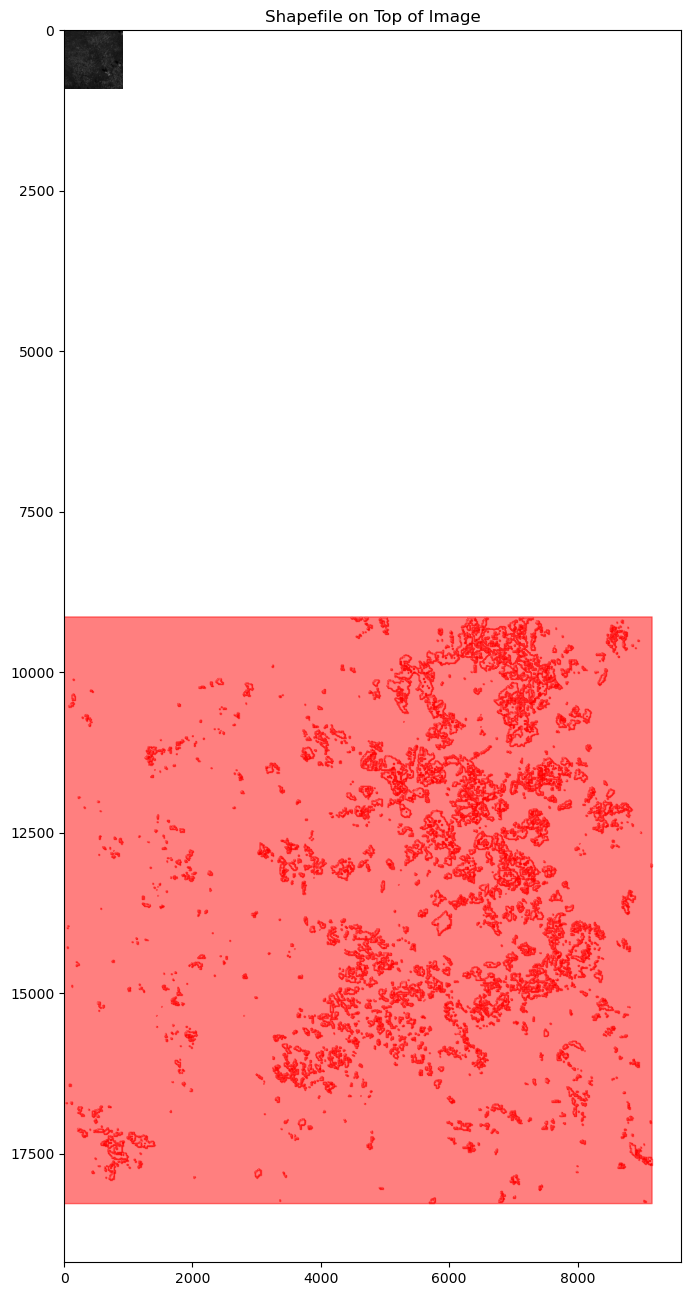

2024-03-24 17:18:38Wait New Raster ::
2024-03-24 17:18:40Found NEW Raster :: 
/Users/imdsk/RIDAProjectBurnScar/Sentinel_Process/Image_Pre/2020/T47QNB_B12.jp2
2024-03-24 17:18:40Raster_Process :: Start GIS Process Please Wait....
2024-03-24 17:18:40Raster_Process :: Delete Old File
2024-03-24 17:18:40Raster_Process :: Delete Old File Complete
2024-03-24 17:18:43Raster_Process :: Resample T47QNB
2024-03-24 17:18:43Raster_Process :: Resample T47QNBB05
2024-03-24 17:18:43Raster_Process :: Resample T47QNBB06
2024-03-24 17:18:43Raster_Process :: Resample T47QNBB07
2024-03-24 17:18:43Raster_Process :: Resample T47QNBB8A
2024-03-24 17:18:44Raster_Process :: Resample T47QNBB09
2024-03-24 17:18:44Raster_Process :: NBR T47QNB
2024-03-24 17:18:44Raster_Process :: Resample T47QNB_20200330T034529_
2024-03-24 17:18:44Raster_Process :: Raster Process T47QNB_20200330T034529
Shape of data_BFNBR: (914, 916)
Shape of data_AFB02: (914, 916)
Shape of data_AFB03: (914, 916)
Shape of data_AFB04: (914, 916)
Sh

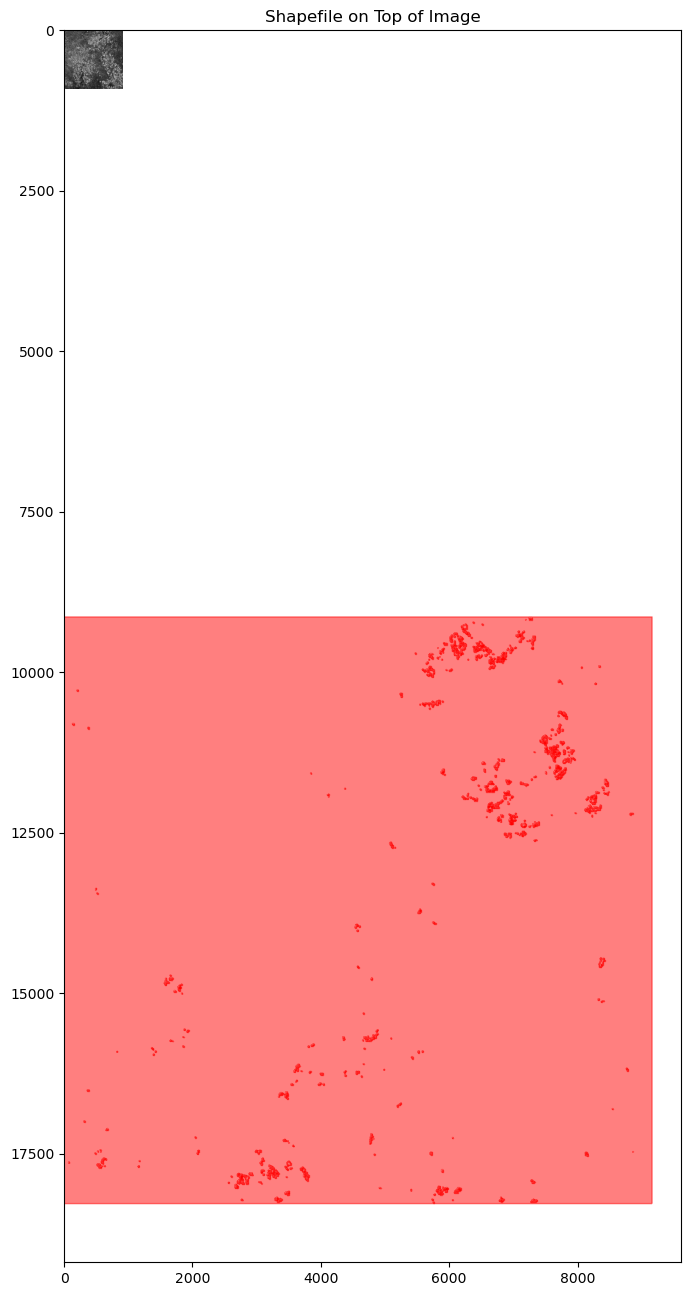

2024-03-24 17:18:55Wait New Raster ::
2024-03-24 17:18:57Found NEW Raster :: 
/Users/imdsk/RIDAProjectBurnScar/Sentinel_Process/Image_Pre/2021/T47QNB_B12.jp2
2024-03-24 17:18:57Raster_Process :: Start GIS Process Please Wait....
2024-03-24 17:18:57Raster_Process :: Delete Old File
2024-03-24 17:18:57Raster_Process :: Delete Old File Complete
2024-03-24 17:19:00Raster_Process :: Resample T47QNB
2024-03-24 17:19:00Raster_Process :: Resample T47QNBB05
2024-03-24 17:19:00Raster_Process :: Resample T47QNBB06
2024-03-24 17:19:00Raster_Process :: Resample T47QNBB07
2024-03-24 17:19:00Raster_Process :: Resample T47QNBB8A
2024-03-24 17:19:01Raster_Process :: Resample T47QNBB09
2024-03-24 17:19:01Raster_Process :: NBR T47QNB
2024-03-24 17:19:01Raster_Process :: Resample T47QNB_20210325T034539_
2024-03-24 17:19:01Raster_Process :: Raster Process T47QNB_20210325T034539
Shape of data_BFNBR: (914, 916)
Shape of data_AFB02: (914, 916)
Shape of data_AFB03: (914, 916)
Shape of data_AFB04: (914, 916)
Sh

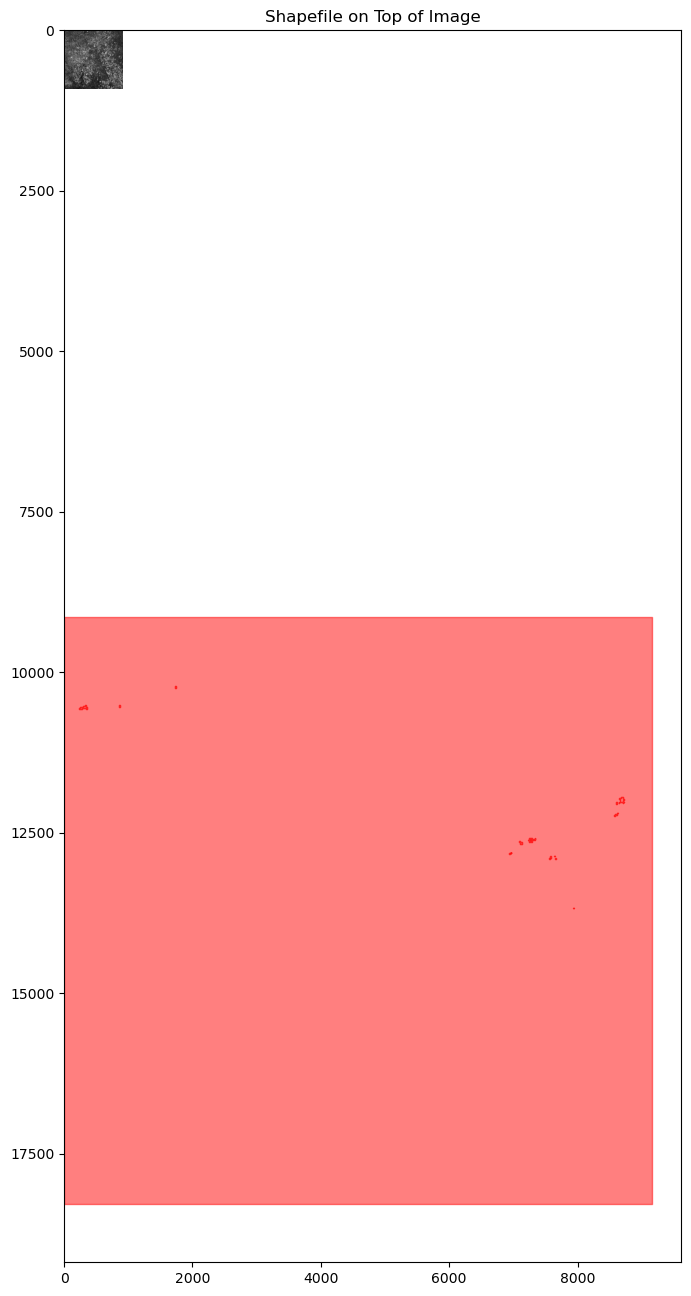

2024-03-24 17:19:11Wait New Raster ::
2024-03-24 17:19:13Found NEW Raster :: 
/Users/imdsk/RIDAProjectBurnScar/Sentinel_Process/Image_Pre/2022/T47QNB_B12.jp2
2024-03-24 17:19:13Raster_Process :: Start GIS Process Please Wait....
2024-03-24 17:19:13Raster_Process :: Delete Old File
2024-03-24 17:19:13Raster_Process :: Delete Old File Complete
2024-03-24 17:19:16Raster_Process :: Resample T47QNB
2024-03-24 17:19:16Raster_Process :: Resample T47QNBB05
2024-03-24 17:19:16Raster_Process :: Resample T47QNBB06
2024-03-24 17:19:16Raster_Process :: Resample T47QNBB07
2024-03-24 17:19:16Raster_Process :: Resample T47QNBB8A
2024-03-24 17:19:17Raster_Process :: Resample T47QNBB09
2024-03-24 17:19:17Raster_Process :: NBR T47QNB
2024-03-24 17:19:17Raster_Process :: Resample T47QNB_20220325T034541_
2024-03-24 17:19:17Raster_Process :: Raster Process T47QNB_20220325T034541
Shape of data_BFNBR: (914, 916)
Shape of data_AFB02: (914, 916)
Shape of data_AFB03: (914, 916)
Shape of data_AFB04: (914, 916)
Sh

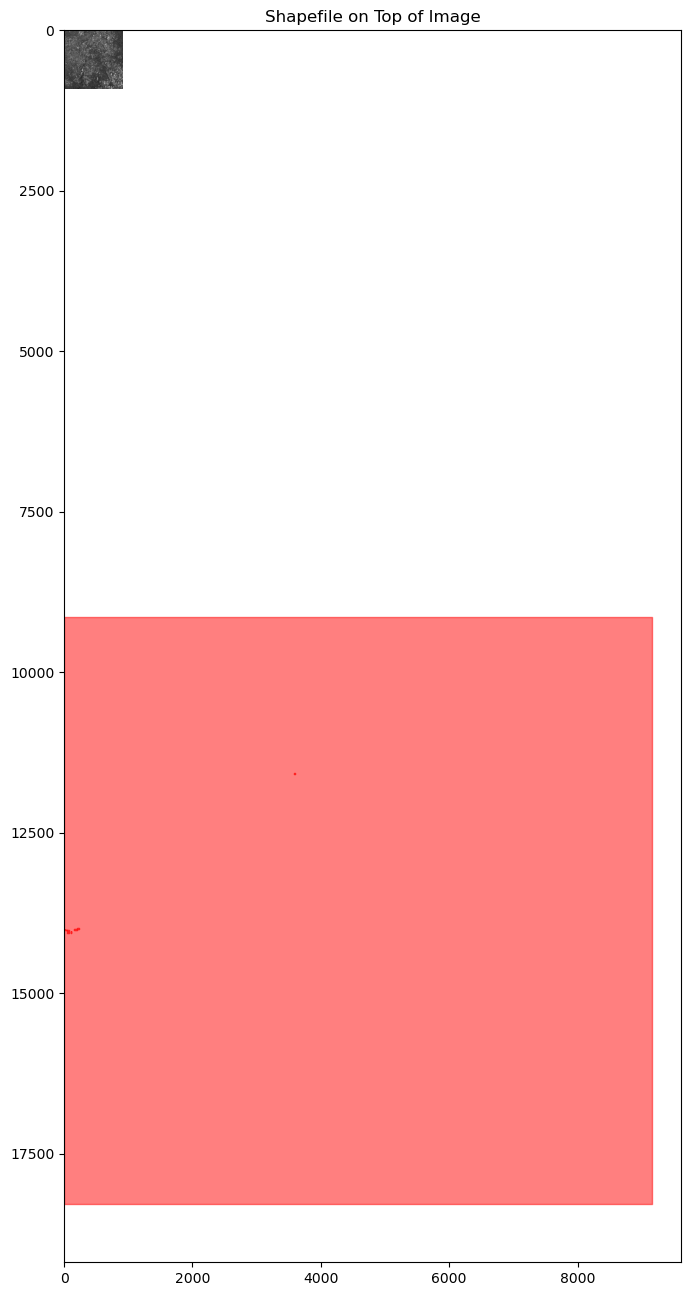

2024-03-24 17:19:26Wait New Raster ::
2024-03-24 17:19:28Found NEW Raster :: 
/Users/imdsk/RIDAProjectBurnScar/Sentinel_Process/Image_Pre/2023/T47QNB_B12.jp2
2024-03-24 17:19:28Raster_Process :: Start GIS Process Please Wait....
2024-03-24 17:19:28Raster_Process :: Delete Old File
2024-03-24 17:19:28Raster_Process :: Delete Old File Complete
2024-03-24 17:19:31Raster_Process :: Resample T47QNB
2024-03-24 17:19:32Raster_Process :: Resample T47QNBB05
2024-03-24 17:19:32Raster_Process :: Resample T47QNBB06
2024-03-24 17:19:32Raster_Process :: Resample T47QNBB07
2024-03-24 17:19:32Raster_Process :: Resample T47QNBB8A
2024-03-24 17:19:32Raster_Process :: Resample T47QNBB09
2024-03-24 17:19:32Raster_Process :: NBR T47QNB
2024-03-24 17:19:32Raster_Process :: Resample T47QNB_20230330T034531_
2024-03-24 17:19:33Raster_Process :: Raster Process T47QNB_20230330T034531
Shape of data_BFNBR: (914, 916)
Shape of data_AFB02: (914, 916)
Shape of data_AFB03: (914, 916)
Shape of data_AFB04: (914, 916)
Sh

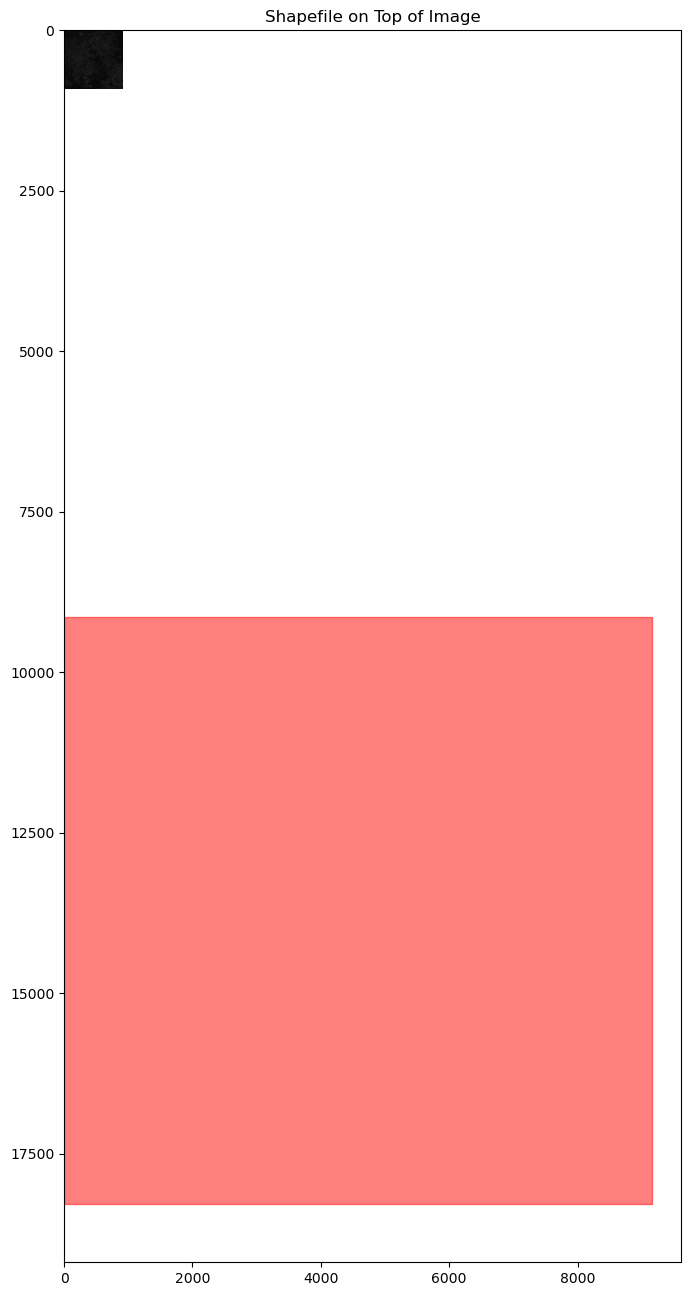

2024-03-24 17:19:42Wait New Raster ::
2024-03-24 17:19:44Found NEW Raster :: 
/Users/imdsk/RIDAProjectBurnScar/Sentinel_Process/Image_Pre/2024/T47QNB_B12.jp2
2024-03-24 17:19:44Raster_Process :: Start GIS Process Please Wait....
2024-03-24 17:19:44Raster_Process :: Delete Old File
2024-03-24 17:19:44Raster_Process :: Delete Old File Complete
2024-03-24 17:19:47Raster_Process :: Resample T47QNB
2024-03-24 17:19:47Raster_Process :: Resample T47QNBB05
2024-03-24 17:19:47Raster_Process :: Resample T47QNBB06
2024-03-24 17:19:48Raster_Process :: Resample T47QNBB07
2024-03-24 17:19:48Raster_Process :: Resample T47QNBB8A
2024-03-24 17:19:48Raster_Process :: Resample T47QNBB09
2024-03-24 17:19:48Raster_Process :: NBR T47QNB
2024-03-24 17:19:48Raster_Process :: Resample T47QNB_20240304T034641_
2024-03-24 17:19:48Raster_Process :: Raster Process T47QNB_20240304T034641
Shape of data_BFNBR: (914, 916)
Shape of data_AFB02: (914, 916)
Shape of data_AFB03: (914, 916)
Shape of data_AFB04: (914, 916)
Sh

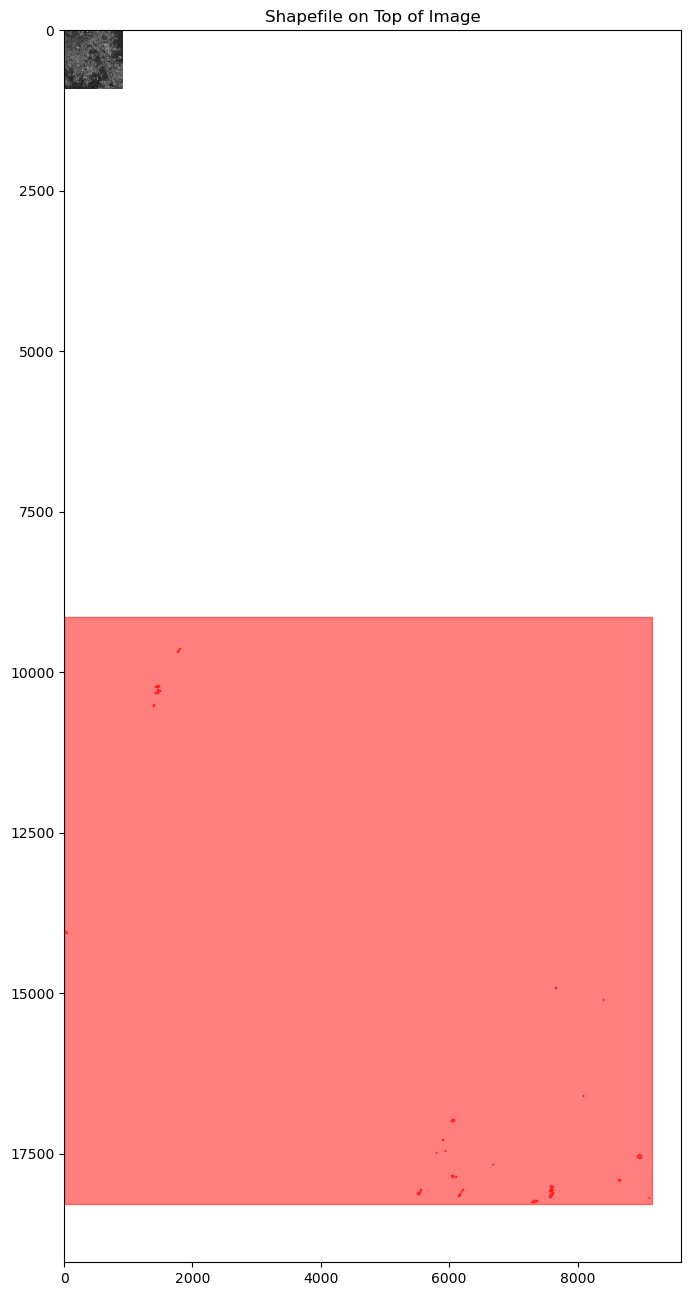

2024-03-24 17:19:58Wait New Raster ::


In [321]:

# def main():
#     current_dir = os.getcwd()
#     print("Current Working Directory:", current_dir)
#     global mode, Image_Post, Track_arr
#     print(print_time() + "Application Start ::")
#     # Initialize mode to True to enter the loop
#     mode = True
#     while mode:  # Now the loop will continue as long as mode is True
#         t = Timer(systemCooldown, loadCooldown)
#         t.start()
#         t.join()
#         if mode:  # This check is redundant given the while condition, but left for clarity
#             for Track in Track_arr:
#                 image_track = os.path.join(Image, Track)
#                 if os.path.exists(image_track):
#                     rasters = [r for r in os.listdir(image_track) if r.endswith('B12.jp2')]
#                     if rasters:
#                         print(print_time() + "Found NEW Raster :: ")
#                         try:
#                             Raster_Process(Track)
#                         except Exception as e:
#                             print(print_time() + "!!!!!!!!!SYSTEM ERROR !!!!!!!!!!")
#                             print(print_time() + str(e))
#                             print(print_time() + "Wait New Raster ::")
#                         # After processing, set mode to False to prevent further looping
#                         print(print_time() + "Your Process is Finished :) ")
#                         mode = False
#                         break  # Exit the for-loop after processing
#                 else:
#                     print(f"Directory not found: {image_track}")  # Inform if the directory does not exist
#         # If mode was set to False, the loop will not execute again

# #Run the main function
# main()

def main():
    current_dir = os.getcwd()
    print("Current Working Directory:", current_dir)
    global mode, Image_Post, Track_arr
    print(print_time() + "Application Start ::")

    track_index = 0  # Initialize the index

    while track_index < len(Track_arr):
        t = Timer(systemCooldown, loadCooldown)
        t.start()
        t.join()

        if mode:
            Track = Track_arr[track_index]  # Get the current Track from the list
            image_track = os.path.join(Image, Track)
            if os.path.exists(image_track):
                rasters = [r for r in os.listdir(image_track) if r.endswith('B12.jp2')]
                if rasters:
                    mode = False
                    print(print_time() + "Found NEW Raster :: ")
                    try:
                        Raster_Process(Track)
                    except Exception as e:
                        print(print_time() + "!!!!!!!!!SYSTEM ERROR !!!!!!!!!!!")
                        print(print_time() + str(e))
                        print(print_time() + "Wait New Raster ::")
                else:
                    print(f"Directory not found: {image_track}")

            track_index += 1  # Move to the next track

# Run the main function
main()


# def main():
#     current_dir = os.getcwd()

#             # Print the current working directory
#     print("Current Working Directory:", current_dir)
#     global mode, Image_Post, Track_arr
#     print(print_time() + "Application Start ::")
#     while True:
#         t = Timer(systemCooldown, loadCooldown)
#         t.start()
#         t.join()
#         if mode:
#             for Track in Track_arr:
#                 image_track = os.path.join(Image, Track)
#                 if os.path.exists(image_track):
#                     rasters = [r for r in os.listdir(image_track) if r.endswith('B12.jp2')]
#                     if rasters:
#                         mode = False
#                         print(print_time() + "Found NEW Raster :: ")
#                         try:
#                             Raster_Process(Track)
#                         except Exception as e:
#                             print(print_time() + "!!!!!!!!!SYSTEM ERROR !!!!!!!!!!")
#                             print(print_time() + str(e))
#                         print(print_time() + "Wait New Raster ::")
#                 else:
#                     print(f"Directory not found: {image_track}")  # Inform if the directory does not exist

# #Run the main function
# main()